# Build Template Database

In this notebook, we use the events detected in notebook 5, and further characterized in notebooks 6 ands 7, to build a database of template events. This step consists mostly in building data and metadata files but also allows the selection of events based on quality and the grouping of similar events. We want to avoid having too many similar templates in the database as it means useless, redundant computation in the template matching process (similar templates detect the same events).

In [1]:
import os
from multiprocessing import cpu_count
n_CPUs = max(cpu_count(), 24)
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
from time import time as give_time
from tqdm import tqdm

from BPMF.data_reader_examples import data_reader_mseed


Matched-filter GPU is not compiled! Should be here: /Users/eric/miniconda3/envs/py312/lib/python3.12/site-packages/fast_matched_filter/lib/matched_filter_GPU.so


In [2]:
# %config InlineBackend.figure_formats = ["svg"]

In [3]:
# program parameters
DB_FILENAME = "reloc_bp.h5"
DB_PATH_T = "template_db"
DATA_FOLDER = "preprocessed_2_12"
NETWORK_FILENAME = "network.csv"


In [4]:
# read network metadata
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()

## Read the database of detected events

We read the database of events detected with backprojection and, with them, create `BPMF.dataset.Template` instances.

In [5]:
# HMAX_LOCATION_UNCERTAINTY_KM: All events with hmax_unc < HMAX_LOCATION_UNCERTAINTY_KM will be selected
#                               as candidate template events
HMAX_LOCATION_UNCERTAINTY_KM = 5.0
# NOISE_WINDOW_FOR_SNR_SEC: Duration, in seconds, of the window taken before the event's origin time
NOISE_WINDOW_FOR_SNR_SEC = 5.0

In [6]:
templates = []
tid = 0

with h5.File(os.path.join(BPMF.cfg.OUTPUT_PATH, DB_FILENAME), mode="r") as f:
    print(f"Checking {DB_FILENAME}...")
    for key in tqdm(f.keys()):
        event = BPMF.dataset.Event.read_from_file(
            DB_FILENAME, db_path=BPMF.cfg.OUTPUT_PATH, gid=key
        )
        if "NLLoc_success" in event.aux_data:
            if event.hmax_unc < HMAX_LOCATION_UNCERTAINTY_KM:
                # if event was well relocated with NLLoc, use its location
                event.set_moveouts_to_theoretical_times()
        event.where = os.path.join(
            BPMF.cfg.INPUT_PATH,
            str(event.origin_time.year),
            event.origin_time.strftime("%Y%m%d"),
        )
        event.read_waveforms(
            BPMF.cfg.TEMPLATE_LEN_SEC,
            data_folder=DATA_FOLDER,
            data_reader=data_reader_mseed,
            n_threads=4
        )
        # computing the signal-to-noise ratio here may add a lot of 
        # computation time if you're scanning through a lot of events,
        # but it greatly helps with choosing the best stations for
        # template matching, in the following
        event.set_availability()
        event.compute_snr(
                noise_window=NOISE_WINDOW_FOR_SNR_SEC,
                data_folder=DATA_FOLDER,
                data_reader=data_reader_mseed,
                )
        template = BPMF.dataset.Template.init_from_event(event)
        template.id = tid
        template.set_aux_data({"tid": tid})
        templates.append(template)
        tid += 1


Checking reloc_bp.h5...


100%|██████████| 17/17 [00:02<00:00,  6.84it/s]


## Remove redundant templates

We first create an `BPMF.dataset.TemplateGroup` instance with the templates built in the previous cell. This class offers a number of methods to operate on groups of templates.

In [7]:
template_group = BPMF.dataset.TemplateGroup(templates, net)
# this trick is necessary to make the class aware that the waveforms are already
# attached to the Template instances (_update_attributes should never be called at
# any other time of the workflow).
template_group._update_attributes.append("read_waveforms")
# normalize the waveforms
template_group.normalize()

In [8]:
# parameters controlling how the inter-template correlation matrix is computed
DISTANCE_THRESHOLD_KM = 5. # in km, criterion on ellipsoid separation
N_CLOSEST_STATIONS = 10 # > larger than total number of stations, i.e. use all stations
MAX_LAG_SAMP = 5 # in samples, maximum time shift allowed when searching for similarity

`TemplateGroup.compute_intertemplate_cc` computes the network-averaged correlation coefficient between templates. To account for possible location errors -- and, therefore, different alignments on the P- and S-wave arrivals -- we search for the maximum correlation within +/- `MAX_LAG_SAMP`.

In [9]:
t1 = give_time()
template_group.compute_intertemplate_cc(
    distance_threshold=DISTANCE_THRESHOLD_KM,
    n_stations=N_CLOSEST_STATIONS,
    save_cc=False,
    max_lag=MAX_LAG_SAMP,
    compute_from_scratch=True,
)
t2 = give_time()
print(f"Computed inter-template CCs in {t2-t1:.2f}sec.")

True ../BPMF_data/2012/intertp_cc.h5 False
Computing the similarity matrix...
Computing the inter-template directional errors...
Computed inter-template CCs in 0.05sec.


/Users/eric/Documents/WORK/software/Seismic_BPMF/BPMF/dataset.py:4582: RuntimeWarning: invalid value encountered in divide
  unit_direction /= np.sqrt(np.sum(unit_direction**2, axis=1))[:, np.newaxis]


In [10]:
template_group.intertemplate_cc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.000000,0.559639,0.000000,0.237905,0.658476,0.125906,0.349816,0.434551,0.305461,0.000000,0.0,0.754021,0.508248,0.770461,0.383099,0.000000,0.174441
1,0.559639,1.000000,0.146489,0.242573,0.504128,0.143789,0.386010,0.454618,0.306094,0.000000,0.0,0.482705,0.359752,0.509030,0.470346,0.000000,0.174221
2,0.000000,0.146489,1.000000,0.203993,0.159324,0.187586,0.182059,0.159073,0.139724,0.185361,0.0,0.142176,0.155862,0.125403,0.183236,0.184122,0.207473
3,0.237905,0.242573,0.203993,1.000000,0.235402,0.184906,0.221147,0.193829,0.180018,0.158489,0.0,0.227727,0.185032,0.215122,0.230660,0.000000,0.182517
4,0.658476,0.504128,0.159324,0.235402,1.000000,0.151123,0.372494,0.430288,0.301853,0.000000,0.0,0.623572,0.578178,0.602277,0.413449,0.000000,0.208349
5,0.125906,0.143789,0.187586,0.184906,0.151123,1.000000,0.149263,0.119723,0.135881,0.000000,0.0,0.117979,0.115291,0.110907,0.153645,0.000000,0.153511
6,0.349816,0.386010,0.182059,0.221147,0.372494,0.149263,1.000000,0.353850,0.314605,0.000000,0.0,0.349831,0.292897,0.338853,0.363107,0.000000,0.162088
7,0.434551,0.454618,0.159073,0.193829,0.430288,0.119723,0.353850,1.000000,0.294828,0.000000,0.0,0.435631,0.372027,0.439064,0.399177,0.000000,0.178389
8,0.305461,0.306094,0.139724,0.180018,0.301853,0.135881,0.314605,0.294828,1.000000,0.000000,0.0,0.339814,0.279266,0.306012,0.306131,0.000000,0.171886
9,0.000000,0.000000,0.185361,0.158489,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.194189,0.000000


In [11]:
# set the threshold to consider two template as redundant
# this parameter is quite arbitrary and really depends on how much computation
# time you are ready to spend in the matched-filter search
# templates with very low correlation coefficients (~0.10) still detect
# many events in common
SIMILARITY_THRESHOLD = 0.50

In [12]:
templates_filtered = []
tids_processed = set()
for tid in template_group.tids:
    if tid in tids_processed:
        continue
    tt = template_group.tindexes.loc[tid]
    similar = template_group.intertemplate_cc.loc[tid] > SIMILARITY_THRESHOLD
    similar_tids = set(template_group.intertemplate_cc[similar].index)
    # comment the following line for a more conservative linkage
    similar_tids.difference_update(tids_processed)
    n_similar = len(similar_tids)
    if n_similar > 1:
        print(f"Template {tid} is similar to: {similar_tids}")
        best_tid = -10
        best_unc = 10000000.0
        for tid_sim in similar_tids:
            tt_sim = template_group.tindexes.loc[tid_sim]
            unc = np.sqrt(
                template_group.templates[tt_sim].hmax_unc ** 2
                + template_group.templates[tt_sim].vmax_unc ** 2
            )
            if unc < best_unc:
                best_unc = unc
                best_tid = tid_sim
        print(f"Keeping only Template {best_tid}")
        ## uncomment if you're using the more conservative linkage
        #if best_tid in tids_processed:
        #    continue
        tids_processed.update(similar_tids)
        templates_filtered.append(
            template_group.templates[
                template_group.tindexes.loc[best_tid]
            ]
        )
    elif n_similar == 0:
        print(
            f"Problem with Template {tid}, it should at least be similar with" " itself"
        )
    else:
        tids_processed.add(tid)
        templates_filtered.append(template_group.templates[tt])


Template 0 is similar to: {0, 1, 4, 11, 12, 13}
Keeping only Template 1


## Plot the similar templates

How good was our criterion to group similar templates together? Let's check the waveforms of the similar templates. The previous cell told us that template 0 is similar to templates 1, 4, 11, 12 and 13.

Text(0.5, 0.98, 'Template 0')

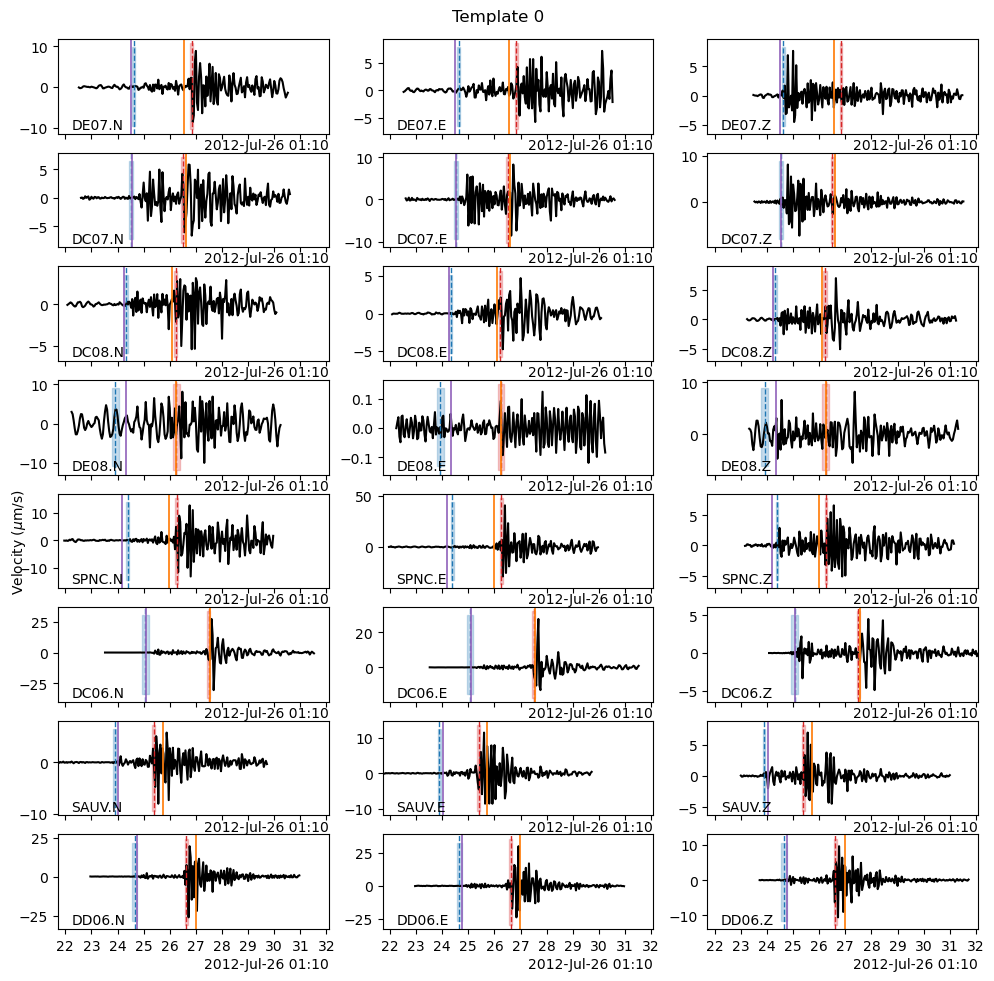

In [16]:
tid = 0
fig = template_group.templates[template_group.tindexes.loc[tid]].plot(figsize=(10, 10))
fig.suptitle(f"Template {tid}")

Text(0.5, 0.98, 'Template 1')

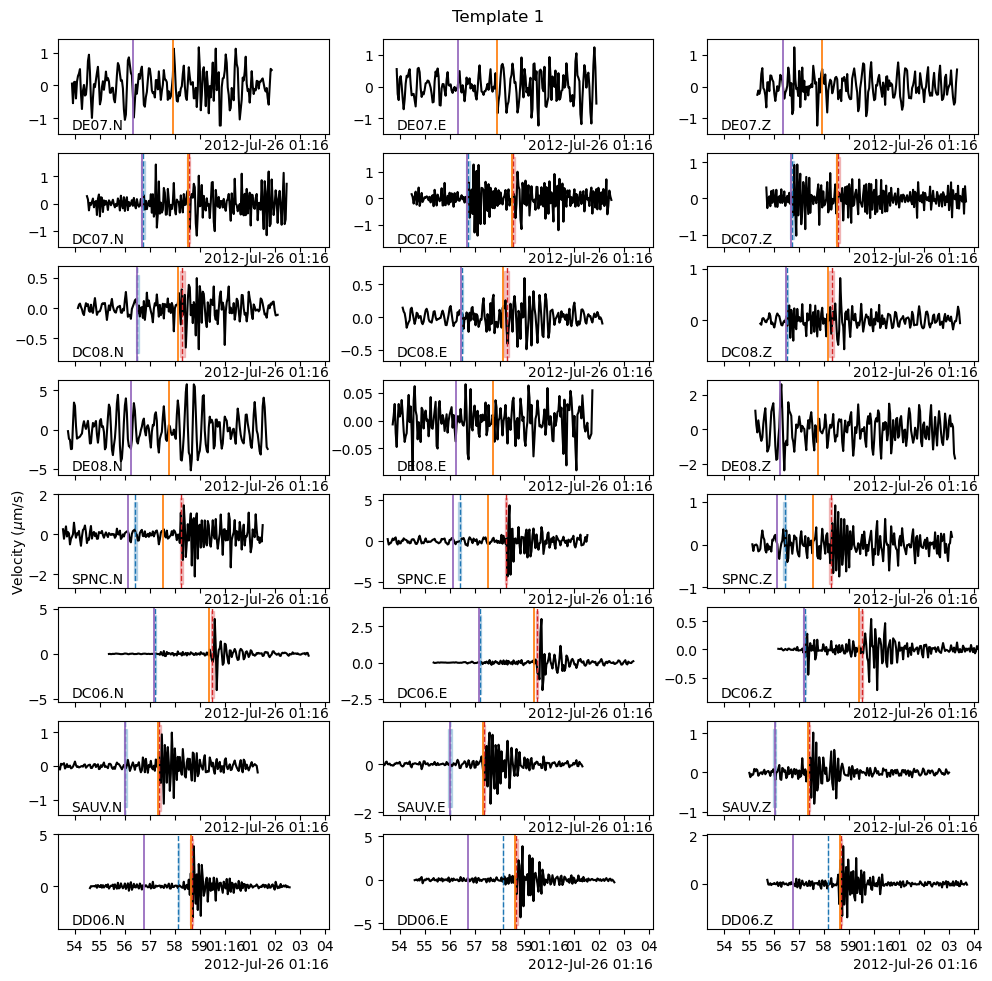

In [17]:
tid = 1
fig = template_group.templates[template_group.tindexes.loc[tid]].plot(figsize=(10, 10))
fig.suptitle(f"Template {tid}")

Let's plot the waveforms of all the templates similar to template 0 on SAUV.E .

Text(0, 0.5, 'Velocity (AU)')

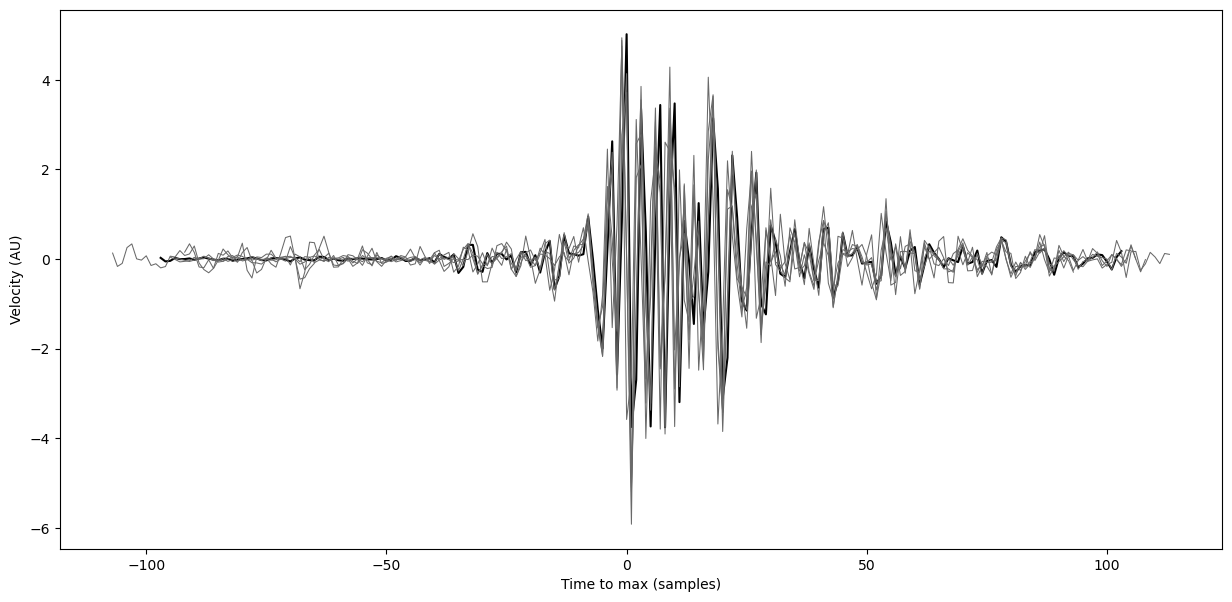

In [18]:
from scipy.signal import hilbert

similar_tids = [0, 1, 4, 11, 12, 13]
fig = plt.figure("waveforms_similar_templates", figsize=(15, 7))
ax = fig.add_subplot(111)
for tid in similar_tids:
    tp = template_group.templates[template_group.tindexes.loc[tid]]
    wav = tp.traces.select(station="SAUV", component="E")[0].data
    norm = np.std(wav)
    # align traces on max of envelope
    time = np.arange(len(wav))
    time -= np.abs(hilbert(wav)).argmax()
    # time -= np.abs(wav).argmax()
    if tid == 0:
        ax.plot(time, wav/norm, color="k", lw=1.5)
    else:
        ax.plot(time, wav/norm, color="dimgrey", lw=0.75)
ax.set_xlabel("Time to max (samples)")
ax.set_ylabel("Velocity (AU)")

The similarity of these templates would make them detect the same events and thus, spending time on redundant computation and writing redundant info in databases.

## Save the non-redundant templates in a database

In [16]:
output_dir = os.path.join(BPMF.cfg.OUTPUT_PATH, DB_PATH_T)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    
for t, template in enumerate(templates_filtered):
    tid = t
    template.id = tid
    template.set_aux_data({"tid": tid})
    full_path = os.path.join(output_dir, f"template{tid}.h5")
    template.write(
        f"template{tid}.h5",
        db_path=output_dir,
        overwrite=True,
    )